##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов" },
    # {"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей"},
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений"},
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        #plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
                                   
    plt.show()
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/nodeCount;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

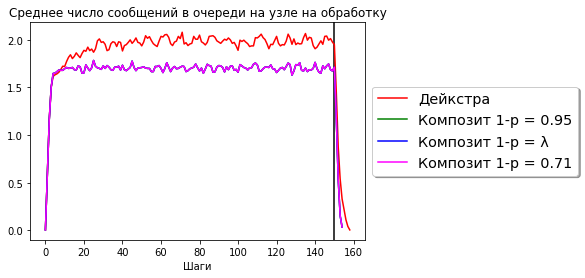

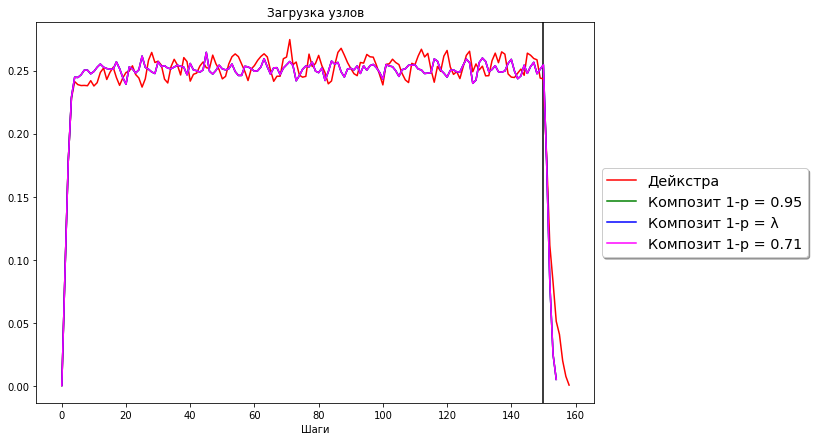

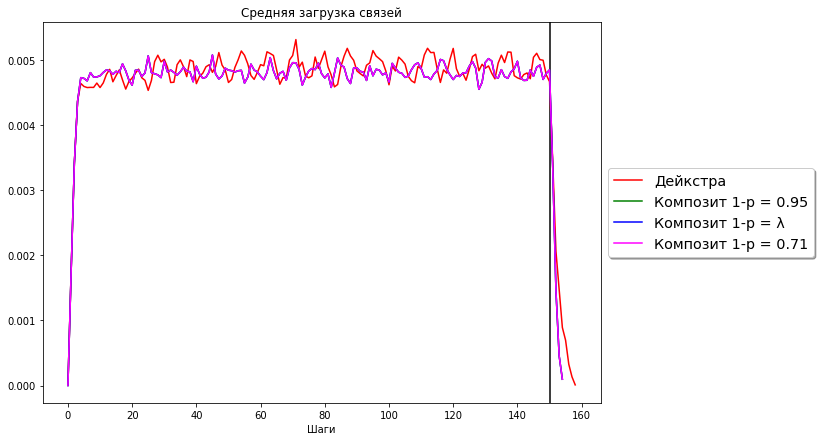

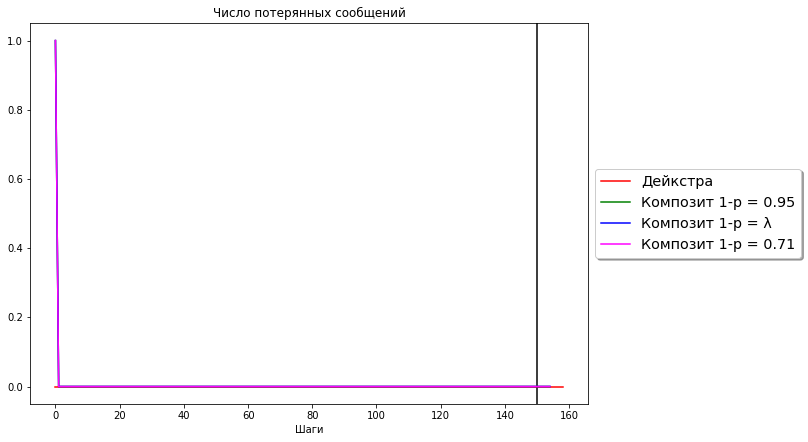

Доставлено 15001 Потеряно 0.0000% -Дейкстра
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = 0.95
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = λ
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = 0.71


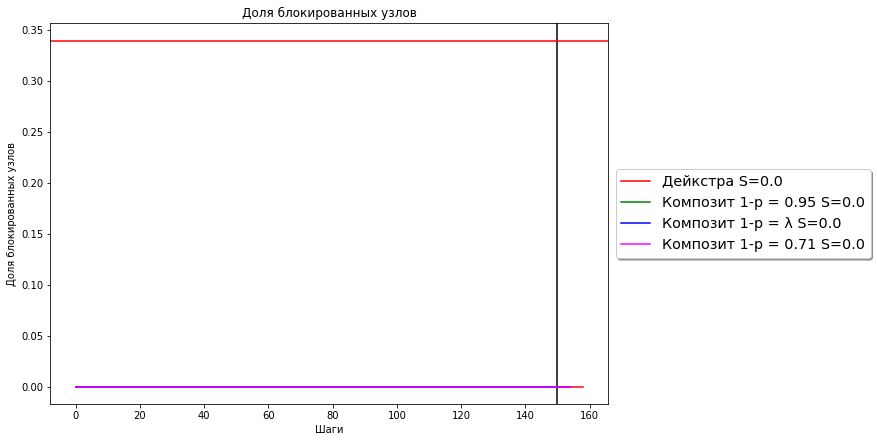

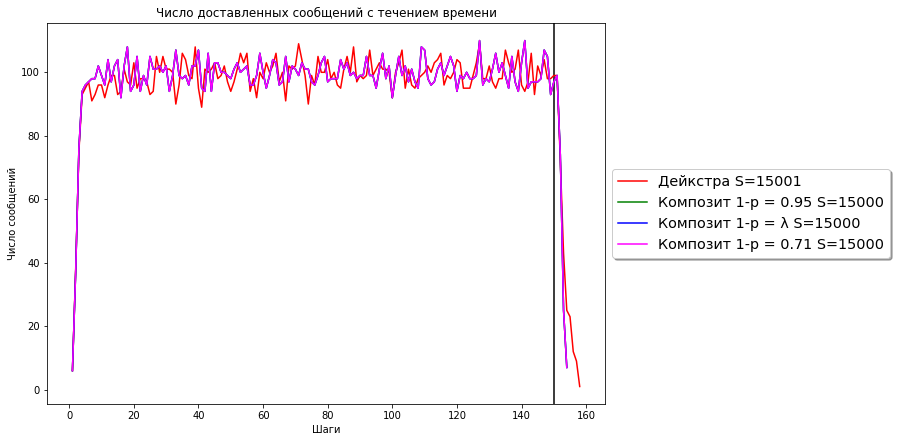

In [2]:
log_tags = [
 {"tag":  "850b838a-77a5-4199-bbce-164a0cd75c21", "label": "Дейкстра", "color": "red"},
 {"tag":  "66872dd3-aad2-4a47-ad59-4de52ed29940", "label": "Композит 1-p = 0.95", "color": "green"},
 {"tag":  "25670473-0add-4173-b8ac-ca6416e8c859", "label": "Композит 1-p = λ", "color": "blue"},
 {"tag":  "229cbe22-9caa-4d9b-9111-98294c4a9439", "label": "Композит 1-p = 0.71", "color": "magenta"},
    #  magenta red green black
]
      
quantity = 100;                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

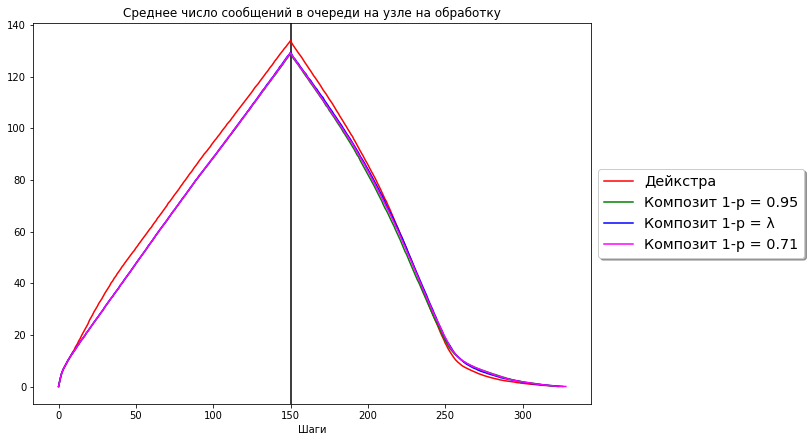

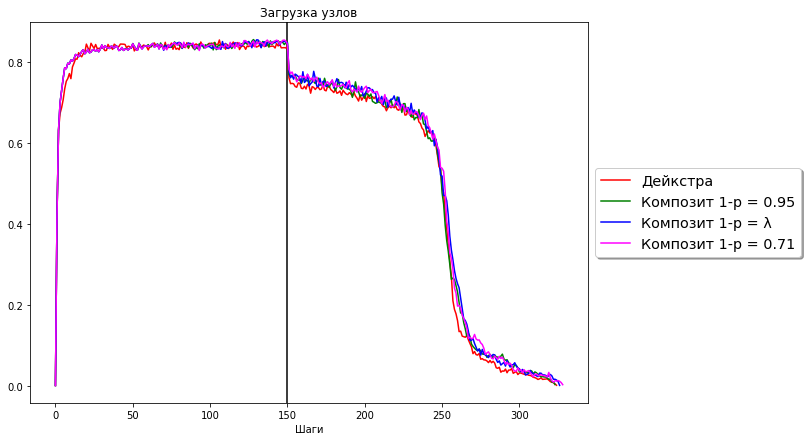

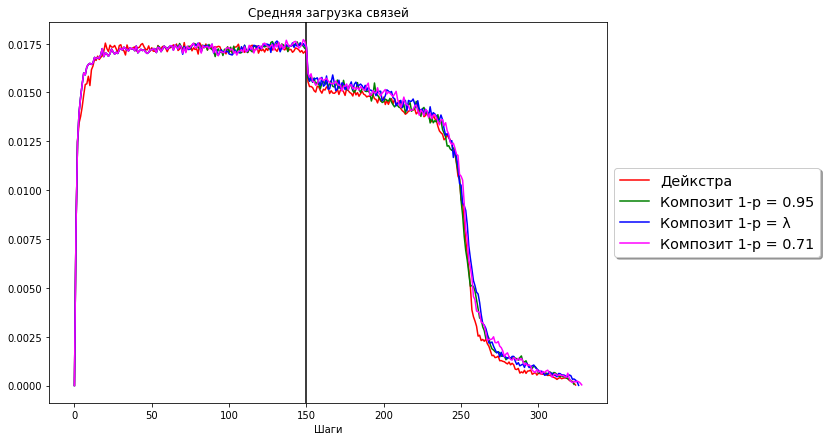

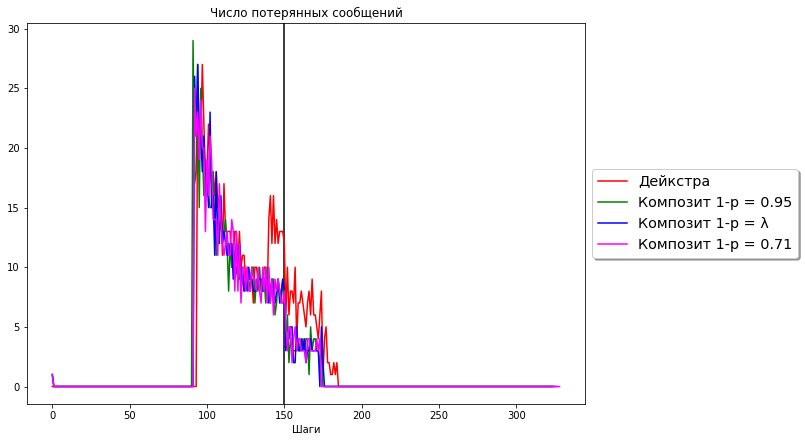

Доставлено 74043 Потеряно 1.2773% -Дейкстра
Доставлено 74210 Потеряно 1.0547% -Композит 1-p = 0.95
Доставлено 74212 Потеряно 1.0520% -Композит 1-p = λ
Доставлено 74211 Потеряно 1.0533% -Композит 1-p = 0.71


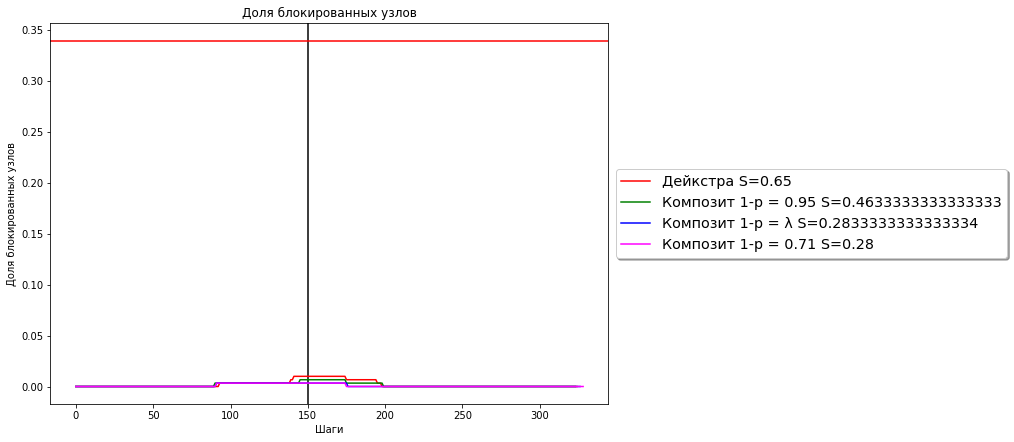

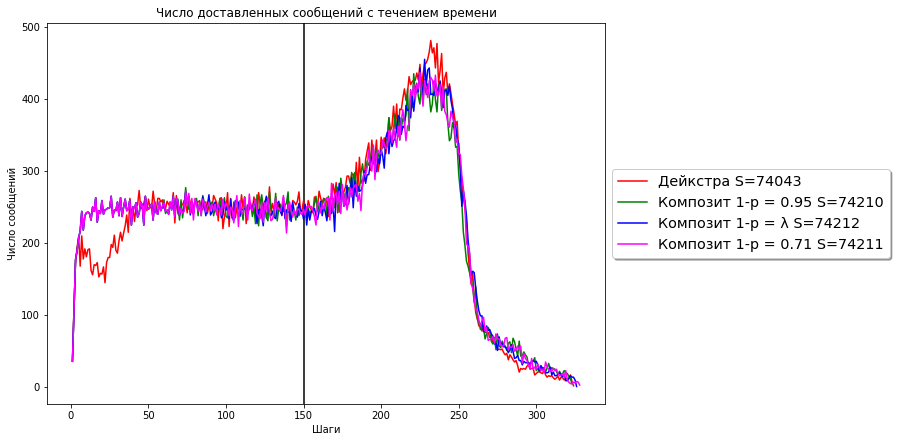

In [3]:
log_tags = [
 {"tag":  "e9cb1790-dc5e-45f4-b0f7-e7a9f5d4fe33", "label": "Дейкстра", "color": "red"},
 {"tag":  "d4757e03-f4de-4e75-b736-821b544dfe17", "label": "Композит 1-p = 0.95", "color": "green"},
 {"tag":  "98a25d7f-726b-46ef-9278-130f4bf19081", "label": "Композит 1-p = λ", "color": "blue"},
 {"tag":  "d38e0288-59ef-4e8c-96ec-75e2f0f6e2e4", "label": "Композит 1-p = 0.71", "color": "magenta"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

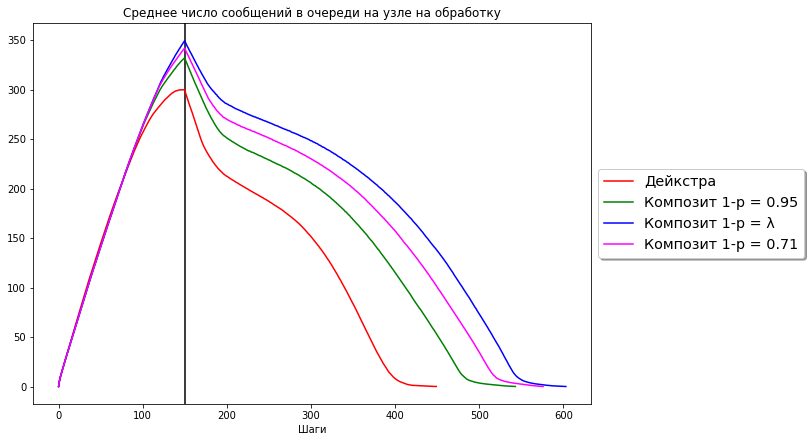

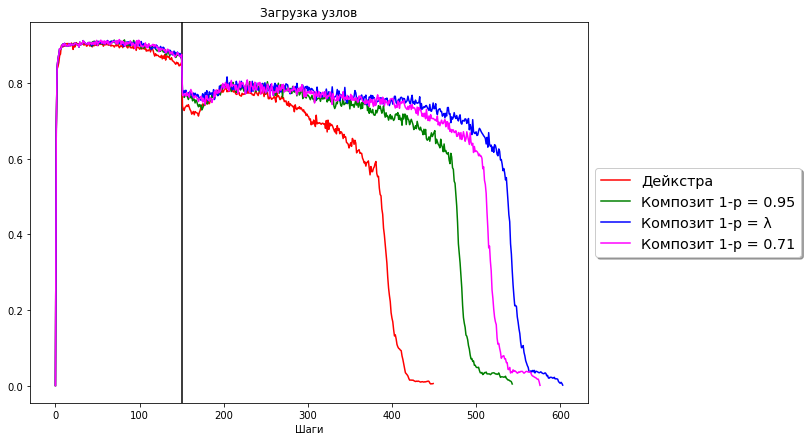

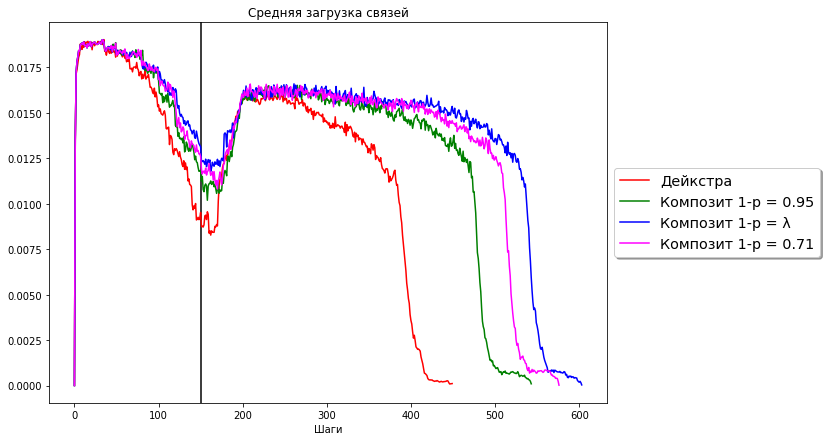

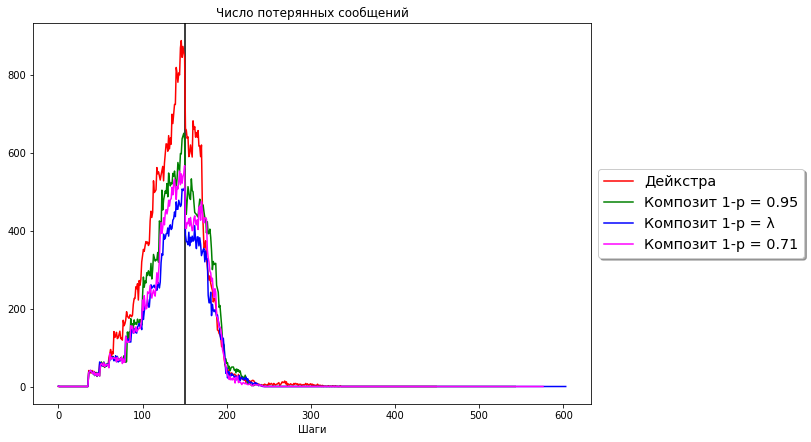

Доставлено 91582 Потеряно 38.9457% -Дейкстра
Доставлено 103156 Потеряно 31.2298% -Композит 1-p = 0.95
Доставлено 113034 Потеряно 24.6445% -Композит 1-p = λ
Доставлено 108983 Потеряно 27.3452% -Композит 1-p = 0.71


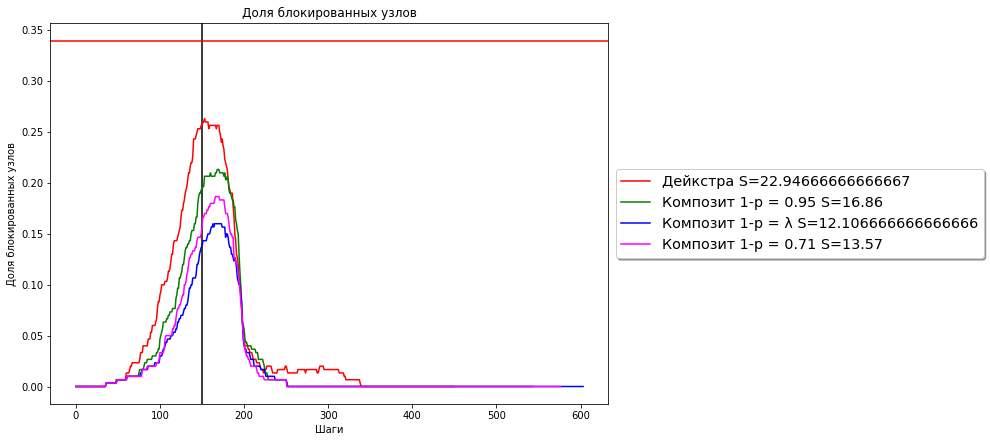

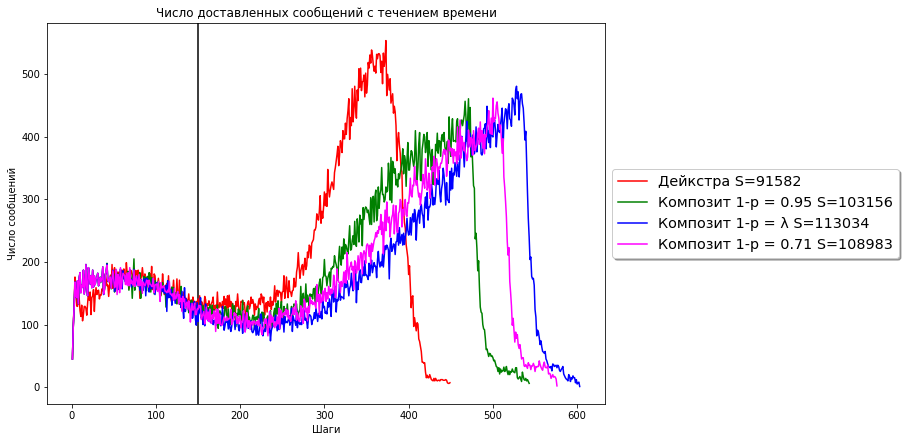

In [4]:
log_tags = [
 {"tag":  "46ac356b-736c-431c-a5f1-d729dd464a0f", "label": "Дейкстра", "color": "red"},
 {"tag":  "8b06eba0-5d75-426c-98b4-25cdfe9a26fc", "label": "Композит 1-p = 0.95", "color": "green"},
 {"tag":  "8f9e718c-2c06-4915-b368-95dfbe42a07f", "label": "Композит 1-p = λ", "color": "blue"},
 {"tag":  "8d340fb5-9894-4db5-9ccf-b43384a67b52", "label": "Композит 1-p = 0.71", "color": "magenta"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

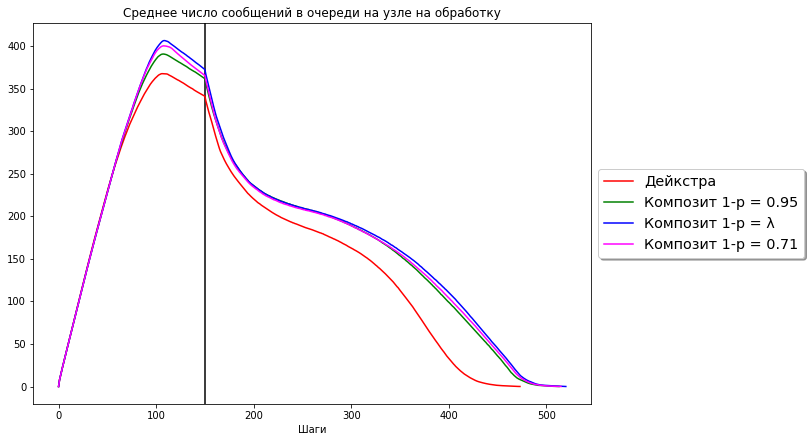

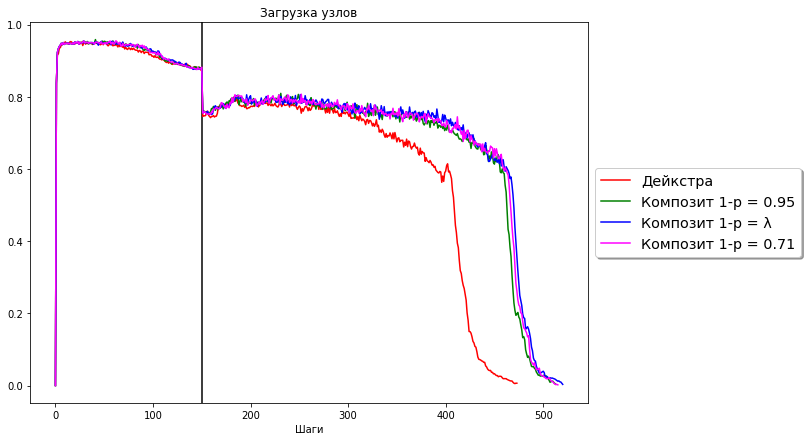

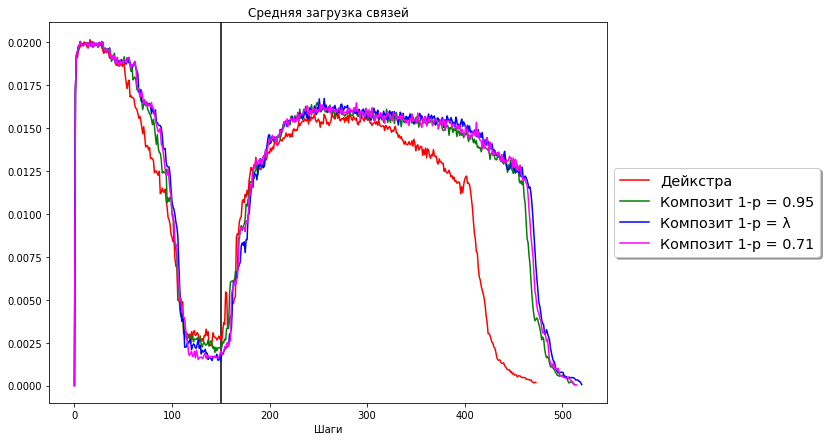

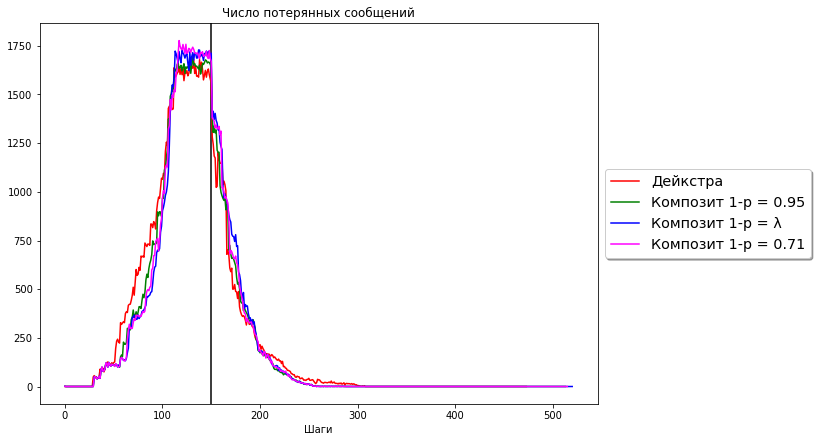

Доставлено 78748 Потеряно 65.0010% -Дейкстра
Доставлено 85118 Потеряно 62.1699% -Композит 1-p = 0.95
Доставлено 84112 Потеряно 62.6171% -Композит 1-p = λ
Доставлено 83928 Потеряно 62.6988% -Композит 1-p = 0.71


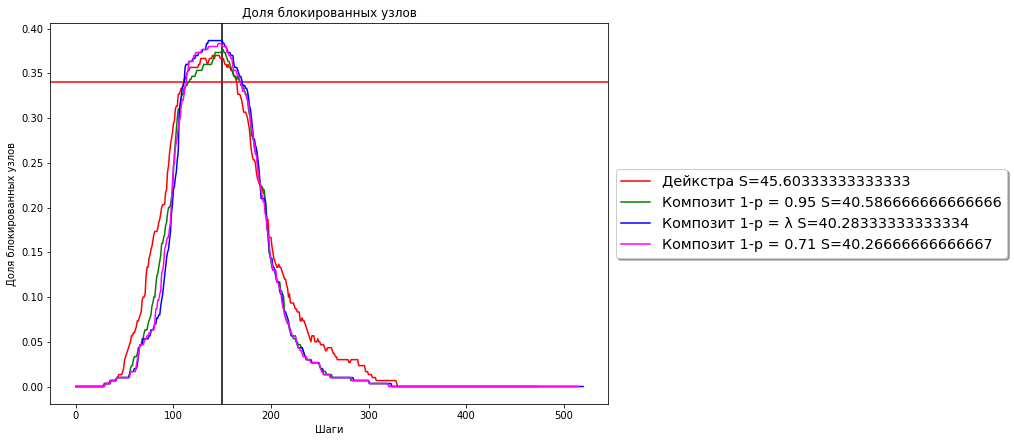

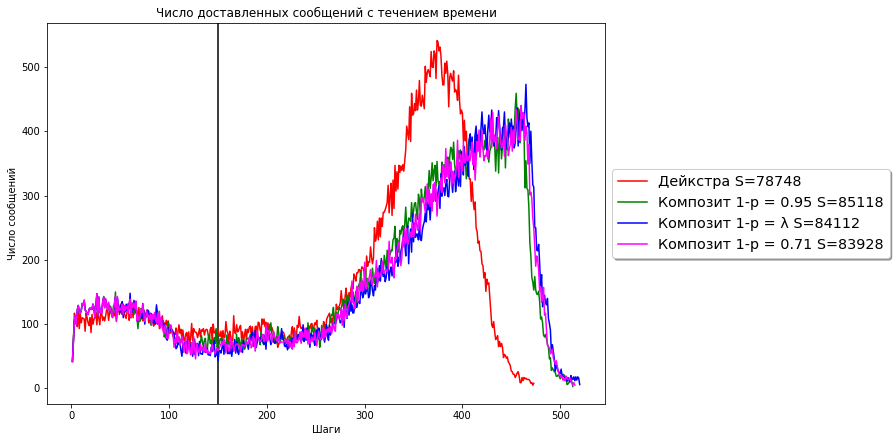

In [5]:
log_tags = [
 {"tag":  "1327951f-1e4b-4ee7-9a3d-e23092633329", "label": "Дейкстра", "color": "red"},
 {"tag":  "e0ca3ab2-a902-4b06-96b9-db892dc1bc99", "label": "Композит 1-p = 0.95", "color": "green"},
 {"tag":  "9ce35a32-1f16-407e-87ac-02da6af36bba", "label": "Композит 1-p = λ", "color": "blue"},
 {"tag":  "290dfd94-aa6f-4f4c-bca2-f66bb61d30ed", "label": "Композит 1-p = 0.71", "color": "magenta"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Text(0, 0.5, 'время доставки')

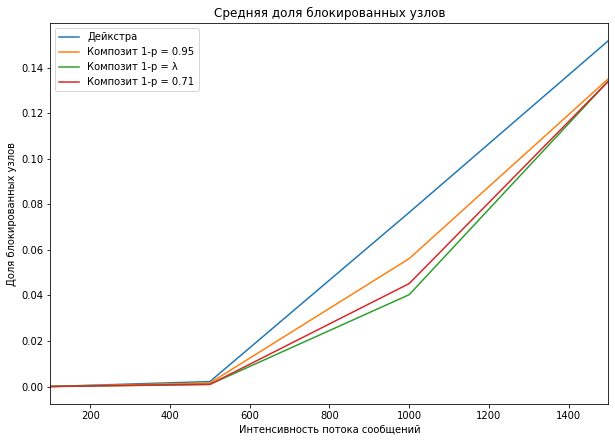

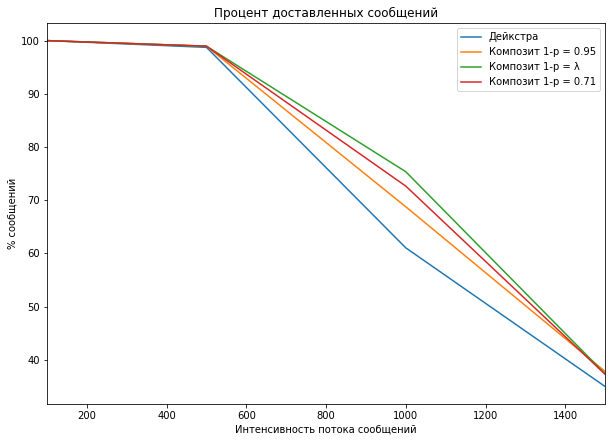

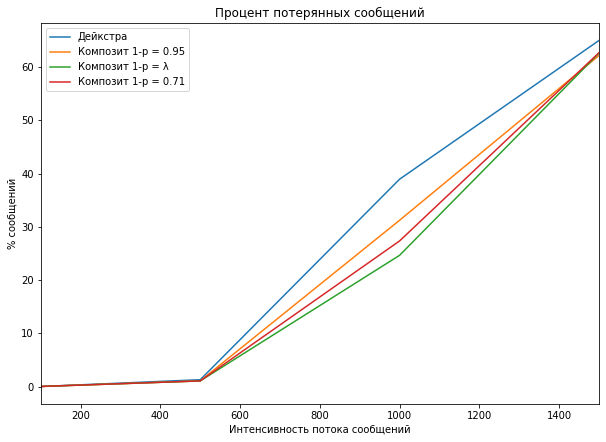

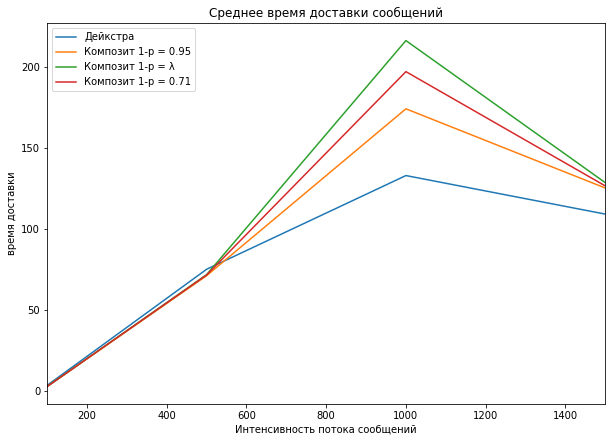

In [6]:
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")

axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")

axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")

axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
